In [1]:
from models import DenseMCDropoutNetwork
from read_data import get_dataset
from query_strategies import random_sampling, bald
from models.losses import tobit_nll
#from datasets import get_dataset
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy
tfd = tfp.distributions
x_train, y_train, censoring_train, x_test, y_test = get_dataset("synth")

11000
(1000,)
(10000, 1)
(10000,)
(10000,)
(1000, 1)
(1000,)


/home/fbohy/censored_active_learning/AL/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#n = 1000
#x = np.random.normal(0,1, size = n)

In [3]:
#t = np.random.binomial(1, tf.sigmoid(x).numpy(), size=len(x))
#ny =  np.random.normal(0,1, size = len(x))

In [4]:
#y = (2*t - 1)*x + (2*t - 1) - 2*np.sin(2*(2*t - 1)*x) + 2*(1 + 0.5*x) + ny

In [5]:
#y[t == 1] = np.clip(y[t == 1], None, 5)

In [6]:
#plt.scatter(x[t != 1],y[t != 1], c='red')
#plt.scatter(x[t == 1],y[t == 1], c='blue')

In [7]:
def visual(active_ids):
    mean = start.net.sample(x)
    plt.figure(figsize=(16,8))
    #plt.plot(x, y_hat)
    for i in range(0,mean.shape[0]):
        plt.plot(x,  mean[i,:,0],'ro', alpha=0.01)
        plt.plot(x,  mean[i,:,2],'bo', alpha=0.01)
        #plt.plot(x, -1*samples[i,:,-1],'ro', alpha=0.01)
    plt.plot(x, np.mean(mean[:,:,0], axis=0))
    plt.plot(x, np.mean(mean[:,:,2], axis=0))
    #plt.plot(x, np.mean(mean, axis=0)+2*np.mean(stds, axis=0), color='green')
    #plt.plot(x, np.mean(mean, axis=0)-2*np.mean(stds, axis=0), color='green')
    
    plt.plot(x, y_true, color='black')
    #plt.scatter(x, y_obs, color='black')
    #plt.scatter(x, y_cens, color='red')
    plt.scatter(x[active_ids], y_cens[active_ids], color='green')
    plt.scatter(x.numpy()[q_ids], y_cens.numpy()[q_ids],color='blue')
    plt.show()

In [8]:
# Do not use GPU
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [9]:
"""Data is generated as follows:
- Define latent function f(x) = 2 + 0.5*sin(2x) + x/10
- Generetae observations from the latent function y_obs (assuming some small observation noise, let's focus on censoring)
- Select the points in the oscillation peaks. 
- Apply a p_c% manual censoring to those points sampled uniformly between [0.2, 0.3] for all selected points.
"""

np.random.seed(10)
n = 1000
# Define underlying function
x = np.linspace(0, 10, n)
y_true = 0.5*np.sin(2*x) + 2 #+ x/10
#y_true = 0.5*x + 2

# Generate noisy observations 
y_obs = y_true + np.random.normal(loc=0, scale=0.01*x, size=x.shape[0]) ## Heterogenue noise
#y_obs = y_true + np.random.normal(loc=0, scale=0.01, size=x.shape[0]) ## Homo noise
y_cens = copy.deepcopy(y_obs)

cens_levl = 2.1
censoring = np.int32(0.5*np.sin(2*x) + 2 >cens_levl) 
#censoring = np.random.choice(2, n, p=[0.1, 0.9])*censoring # this can be used to uncensor some.
p_c = np.random.uniform(low=0.10, high=0.30, size=np.sum(censoring==1))
#y_cens[censoring == 1] = y_obs[censoring == 1]*(1-p_c)
y_cens[censoring == 1] = cens_levl + np.random.normal(loc=0, scale=0.01, size=sum(censoring))

x = x.reshape(n,1)

In [10]:
quantiles = [0.05, 0.5, 0.95]
model_args = {'in_features':1, 'out_features':len(quantiles),'hidden_size':[512,512,512,512]}

In [11]:
init_size = 25
query_size = 5
n_rounds = 10
trials = 1

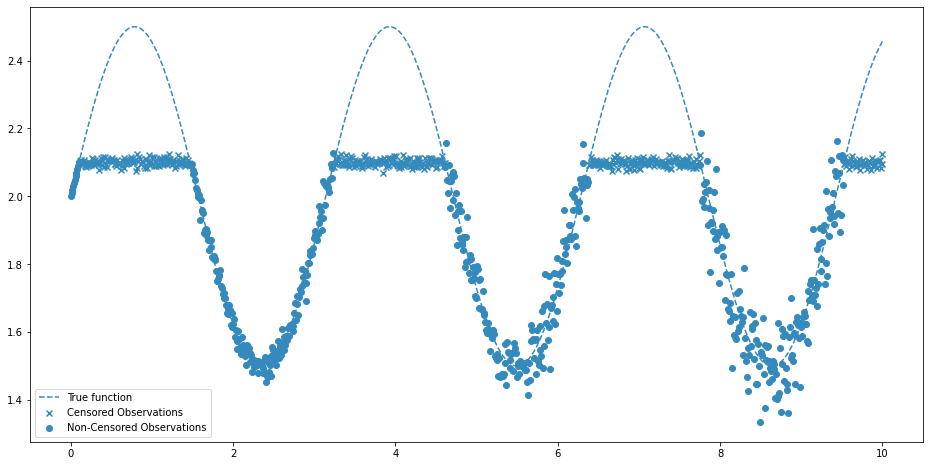

In [12]:
plt.figure(figsize=(16,8))
plt.plot(x, y_true, linestyle="--", label="True function", color='#348ABD')
plt.scatter(x[censoring==1].reshape(-1,1), y=y_cens[censoring==1].reshape(-1,1), marker="x", label="Censored Observations", color='#348ABD')
plt.scatter(x[censoring==0].reshape(-1,1), y=y_cens[censoring==0].reshape(-1,1), marker="o", label="Non-Censored Observations", color='#348ABD');
plt.legend()

In [14]:
random = np.zeros([trials, n_rounds])
bald_ = np.zeros([trials, n_rounds])
results = np.zeros([trials, n_rounds])

In [16]:
#x = tf.convert_to_tensor(x)
#y_cens = tf.convert_to_tensor(y_cens)
#y_true = tf.convert_to_tensor(y_true)

In [17]:
active_ids = np.zeros(x.shape[0], dtype = bool)
active_ids[np.random.choice(np.where((x < 3.0) | (x > 5.6))[0], init_size, replace=False)] = True
start = bald.BaldSampling(x, y_cens, censoring, active_ids, model_args)

In [18]:
start.net


BayesianNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc1_drop): ConsistentMCDropout(p=0.2)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc2_drop): ConsistentMCDropout(p=0.2)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [22]:
samples = np.mean(samples, axis=0)

In [26]:
tmp = np.concatenate((y_true[:,np.newaxis], y_true[:,np.newaxis]), axis=1) # quick hack to fit dimensions.

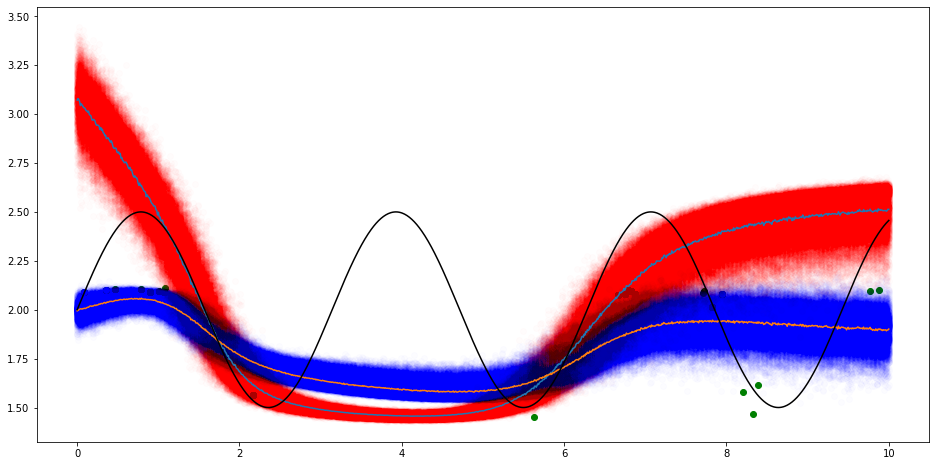

KeyboardInterrupt: 

: 

In [28]:
active_ids = np.zeros(x.shape[0], dtype = bool)
active_ids[np.random.choice(np.where((x < 3.0) | (x > 5.6))[0], init_size, replace=False)] = True
#ids_tmp = np.arange(x.shape[0])
#active_ids[np.random.choice(ids_tmp,init_size, replace=False)] = True
active_ids_2 = active_ids.copy()

for k in range(0, trials):
    start = random_sampling.RandomSampling(x, y_cens, censoring, active_ids_2, model_args)
    start.train()
    results[k,0] = start.evaluate(x, y_true)
    #print(results[k,0])
    for i in range(1,n_rounds):
        q_ids = start.query(query_size)
        active_ids_2[q_ids] = True
        visual(active_ids_2)
        start.update(active_ids_2)
        start.train()
        results[k,i] = start.evaluate(x, y_true)
        
    start = bald.BaldSampling(x, y_cens, censoring, active_ids, model_args)
    start.train()
    bald_[k,0] = start.evaluate(x, y_true)
    #print(results[k,0])
    for i in range(1,n_rounds):
        q_ids = start.query(query_size)
        active_ids[q_ids] = True
        visual(active_ids)
        start.update(active_ids)
        start.train()
        bald_[k,i] = start.evaluate(x, y_true)


In [ ]:
idxs_unlabeled = np.arange(self.Y.shape[0])[~self.ids]
samples = self.net.sample(self.X.numpy()[idxs_unlabeled])

[]

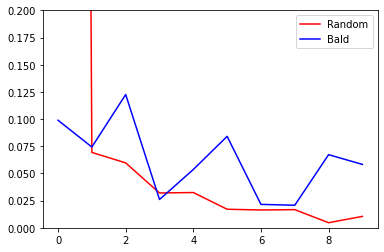

In [ ]:
plt.plot(np.mean(results,axis=0),'r', label='Random')
plt.plot(np.mean(bald_,axis=0),'b', label='Bald')
plt.ylim(0,0.2)
plt.legend()
plt.plot()